In [13]:
import os
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras import backend as K
from keras import regularizers


In [14]:
fname = os.path.join('jena_climate_2009_2016.csv', 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [15]:
lines[0]

'01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30'

In [16]:
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [17]:
float_data.shape
values

[999.82,
 -4.82,
 268.36,
 -8.42,
 75.7,
 4.27,
 3.23,
 1.04,
 2.01,
 3.23,
 1296.38,
 1.23,
 1.96,
 184.9]

In [18]:
mean = float_data[:200000].mean(axis=0)
print(mean)
float_data -= mean
std = float_data[:200000].std(axis=0)
print(std)
float_data /= std

[ 988.88635885    9.07734895  283.14631345    4.44854725   75.35405895
   13.3829553     9.29695535    4.08591725    5.8752111     9.40521005
 1217.51429655    2.1510037     3.56950915  176.21703355]
[ 8.48043388  8.85249908  8.95324185  7.16584991 16.72731652  7.68914559
  4.19808168  4.84034436  2.66564926  4.25206364 42.48884277  1.53666449
  2.33067298 86.61322998]


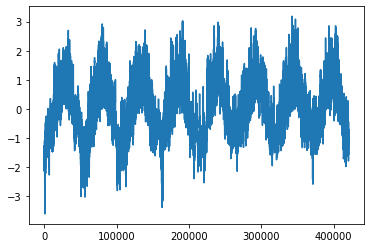

In [19]:
from matplotlib import pyplot as plt
temp = float_data[:, 1] # температура (в градусах Цельсия)
plt.plot(range(len(temp)), temp)
plt.show()

In [20]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [21]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step, batch_size=batch_size)

In [22]:
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [23]:
model = Sequential()
model.add(layers.GRU(32, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20


InvalidArgumentError: No OpKernel was registered to support Op 'CudnnRNN' used by node cu_dnngru_1/CudnnRNN (defined at C:\Users\a.lunev\Anaconda3\envs\ML_CPU\lib\site-packages\keras\layers\cudnn_recurrent.py:297) with these attrs: [seed=87654321, dropout=0, T=DT_FLOAT, input_mode="linear_input", direction="unidirectional", rnn_mode="gru", seed2=0, is_training=true]
Registered devices: [CPU]
Registered kernels:
  <no registered kernels>

	 [[cu_dnngru_1/CudnnRNN]]

Errors may have originated from an input operation.
Input Source operations connected to node cu_dnngru_1/CudnnRNN:
 cu_dnngru_1/transpose (defined at C:\Users\a.lunev\Anaconda3\envs\ML_CPU\lib\site-packages\keras\layers\cudnn_recurrent.py:271)	
 cu_dnngru_1/concat (defined at C:\Users\a.lunev\Anaconda3\envs\ML_CPU\lib\site-packages\keras\layers\cudnn_recurrent.py:60)	
 cu_dnngru_1/ExpandDims_1 (defined at C:\Users\a.lunev\Anaconda3\envs\ML_CPU\lib\site-packages\keras\layers\cudnn_recurrent.py:273)

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

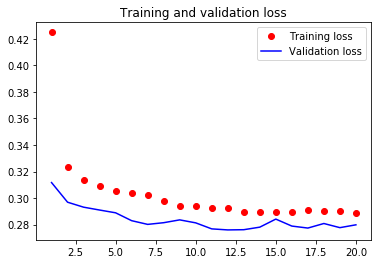

In [68]:
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()